In [5]:
# Fix for module imports - add parent directory to Python path
import sys
import os

# Get the parent directory (project root) and add it to Python path
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Added to Python path: {project_root}")
print("Now you can import from modules package!")


Added to Python path: /Users/josiasmoukpe/Desktop/sep-forecasting-research
Now you can import from modules package!


In [7]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import psutil
import tensorflow as tf
from scipy.stats import pearsonr
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.models import Model

from modules.training.normlayer import NormalizeLayer
from modules.training.phase_manager import IsTraining

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

from modules.training.cme_modeling import ModelBuilder as MB

In [8]:
from modules.training.phase_manager import TrainingPhaseManager

# instantiate the model_builder
mb = MB()
pm = TrainingPhaseManager()  # Training phase manager

In [9]:
def benchmark_function(func, args=(), kwargs=None, num_runs=100):
    """
    Generic benchmark utility for any function.
    
    :param func: Function to benchmark
    :param args: Tuple of positional arguments for the function
    :param kwargs: Dictionary of keyword arguments for the function
    :param num_runs: Number of runs for averaging timing
    :return: Dictionary containing timing and memory statistics
    """
    if kwargs is None:
        kwargs = {}
    global result
    process = psutil.Process(os.getpid())
    execution_times = []
    memory_usages = []

    # Warmup run
    _ = func(*args, **kwargs)

    # Clear any cached memory
    tf.keras.backend.clear_session()

    for _ in range(num_runs):
        mem_before = process.memory_info().rss / 1024 / 1024

        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()

        mem_after = process.memory_info().rss / 1024 / 1024

        execution_times.append(end_time - start_time)
        memory_usages.append(mem_after - mem_before)

        tf.keras.backend.clear_session()

    times_ms = np.array(execution_times) * 1000
    memory_mb = np.array(memory_usages)

    return {
        'time_mean_ms': np.mean(times_ms),
        'time_std_ms': np.std(times_ms),
        'memory_mean_mb': np.mean(memory_mb),
        'memory_max_mb': np.max(memory_mb),
        'last_result': result
    }

In [10]:
y_true = tf.constant([[1.0],
                      [5.0],
                      [0.0]])

z_pred = tf.constant([[1.0, 1.0],
                      [2.0, -1.0],
                      [3.0, 1.0]])

# create sample weights dictionary of label weights pairs
# Create dictionary mapping label values to weights
sample_weights = {
    1.0: 0.5,  # Weight for label 1.0
    5.0: 1.0,  # Weight for label 5.0 
    0.0: 0.8  # Weight for label 0.0
}

# print shapes
print(f"y_true shape: {y_true.shape}")
print(f"z_pred shape: {z_pred.shape}")

y_true shape: (3, 1)
z_pred shape: (3, 2)


In [11]:
res = mb.pds_loss_vec(y_true, z_pred, pm, train_sample_weights=sample_weights)
print(f'Result: {res.numpy():.4f}')

Result: 2.6891


In [12]:
res = mb.pds_loss_linear_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 3.9169


In [13]:
res = mb.pdc_loss_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 0.0293


In [14]:
res = mb.pdc_loss_linear_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 0.0293


In [15]:
# Parameters
num_points = 5000  # 201 points for labels from -100 to 100 inclusive

# Create evenly spaced labels from -100 to 100
labels = np.linspace(-5000, 5000, num_points)
# update the dimension of labels
labels = np.expand_dims(labels, axis=1)

# Generate points like (0, 0), (1, 1), ..., (200, 200)
points = np.array([(i, i) for i in range(num_points)])

# convert to tensor float32
labels = tf.constant(labels, dtype=tf.float32)
points = tf.constant(points, dtype=tf.float32)

print(f"Labels shape: {labels.shape}")
print(f"Points shape: {points.shape}")

# Random sample weights between 0 and 1
sample_weights = np.random.rand(num_points)

Labels shape: (5000, 1)
Points shape: (5000, 2)


In [16]:
stats = benchmark_function(
    mb.pds_loss_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 1432013.8750
Time: 61.553 ± 0.914 ms
Memory peak: 0.859 MB


In [17]:
stats = benchmark_function(
    mb.pds_loss_linear_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 1431728.1250
Time: 4.301 ± 0.303 ms
Memory peak: 0.422 MB


In [18]:
stats = benchmark_function(
    mb.pdc_loss_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 0.0000
Time: 81.349 ± 2.177 ms
Memory peak: 0.078 MB


In [19]:
stats = benchmark_function(
    mb.pdc_loss_linear_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: -0.0000
Time: 4.904 ± 0.232 ms
Memory peak: 0.234 MB


In [20]:
class TrainerV4:
    def __init__(self, input_dim=2, hidden_dims=None, output_dim=2):
        if hidden_dims is None:
            hidden_dims = [64, 32]
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()
        self.convergence_threshold = None

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers with Leaky ReLU activation
        for dim in self.hidden_dims:
            x = Dense(dim)(x)
            x = LeakyReLU()(x)

        # Output layer
        outputs = Dense(self.output_dim)(x)
        outputs = NormalizeLayer(name='normalize_layer')(outputs)
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def generate_synthetic_data(self, num_points=200, noise_level=0.15):
        """
        Generate synthetic data where:
        - Features are random 2D points with coordinates between 0 and 1
        - Labels are distances from origin (0,0)
        - Middle distances are ~10x more frequent than extremes
        - noise_level controls the spread of the gaussian weighting (default 0.15)
        """
        # Generate more points than needed for sampling
        pool_size = num_points * 10
        features = np.random.uniform(0, 1, (pool_size, self.input_dim))

        # Calculate distances
        distances = np.sqrt(np.sum(features ** 2, axis=1))

        # Create weights favoring middle distances
        # Use a gaussian centered at ~0.75 (middle of the possible range 0 to √2)
        weights = np.exp(-((distances - 0.75) ** 2) / (2 * noise_level ** 2))

        # Normalize weights to probabilities
        weights = weights / np.sum(weights)

        # Sample indices according to weights
        selected_indices = np.random.choice(
            pool_size,
            size=num_points,
            p=weights,
            replace=False
        )

        # Select the points
        selected_features = features[selected_indices]
        selected_distances = distances[selected_indices]

        return selected_features, selected_distances.reshape(-1, 1)

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions."""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, _ = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation

    def train(self, loss_fn, num_points=2000, epochs=1000, batch_size=32, noise_level=0.15, verbose=1):
        # Generate synthetic data with specified noise level
        X_train, y_train = self.generate_synthetic_data(num_points=num_points, noise_level=noise_level)

        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=loss_fn
        )

        # Convert to tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.batch(batch_size)

        # Initialize tracking variables
        start_time = time.time()
        batch_times = []
        convergence_epoch = None
        convergence_time = None

        class ConvergenceCallback(tf.keras.callbacks.Callback):
            def __init__(self, trainer, threshold_factor=0.0007):
                super().__init__()
                self.trainer = trainer
                self.threshold_factor = threshold_factor
                self.first_loss = None
                self.convergence_reached = False
                self.batch_start_time = None

            def on_train_begin(self, logs=None):
                self.batch_start_time = time.time()

            def on_batch_end(self, batch, logs=None):
                batch_end_time = time.time()
                batch_duration = batch_end_time - self.batch_start_time
                batch_times.append(batch_duration)
                self.batch_start_time = batch_end_time

            def on_epoch_end(self, epoch, logs=None):
                current_loss = logs['loss']

                if self.first_loss is None:
                    self.first_loss = current_loss
                    self.trainer.convergence_threshold = self.first_loss * self.threshold_factor

                if not self.convergence_reached and current_loss <= self.trainer.convergence_threshold:
                    self.convergence_reached = True
                    nonlocal convergence_epoch, convergence_time
                    convergence_epoch = epoch + 1
                    convergence_time = time.time() - start_time

        convergence_callback = ConvergenceCallback(self)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[
                IsTraining(self.phase_manager),
                convergence_callback
            ]
        )

        # Final predictions
        predictions = self.model.predict(X_train)

        # Compute final correlation
        correlation = self.compute_pairwise_correlation(X_train, predictions)

        # Calculate and print metrics
        total_time = time.time() - start_time
        avg_batch_time = np.mean(batch_times)

        print("\nTraining Metrics:")
        print(f"Initial Loss: {history.history['loss'][0]:.6f}")
        print(f"Final Loss: {history.history['loss'][-1]:.6f}")
        print(f"Convergence Threshold: {self.convergence_threshold:.6f}")
        if convergence_epoch:
            print(f"Convergence Epoch: {convergence_epoch}")
            print(f"Loss at Convergence: {history.history['loss'][convergence_epoch - 1]:.6f}")
            print(f"Time to Convergence: {convergence_time:.2f} seconds")
        else:
            print("Model did not converge to threshold")
        print(f"Total Training Time: {total_time:.2f} seconds")
        print(f"Average Time per Batch: {avg_batch_time * 1000:.2f} ms")
        print(f"Final Correlation: {correlation:.4f}")
        print(f"Noise Level Used: {noise_level}")

        return history, correlation

    def plot_training_history(self, history):
        """Plot the training loss over epochs."""
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.axhline(y=self.convergence_threshold, color='r', linestyle='--',
                    label=f'Convergence Threshold ({self.convergence_threshold:.6f})')
        plt.title('Model Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  # Use log scale to better see convergence
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_data_distribution(self, features, labels):
        """Plot the distribution of data points and their labels."""
        plt.figure(figsize=(15, 5))

        # Plot points in 2D space
        plt.subplot(1, 3, 1)
        scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Origin')
        plt.title('Data Points Colored by Distance')
        plt.xlabel('X')
        plt.ylabel('Y')

        # Plot distance distribution
        plt.subplot(1, 3, 2)
        plt.hist(labels, bins=30, density=True)

        # Add the target distribution curve
        x = np.linspace(0, np.sqrt(2), 100)
        target_dist = np.exp(-((x - 0.75) ** 2) / (2 * 0.15 ** 2))
        target_dist = target_dist / np.max(target_dist) * plt.gca().get_ylim()[1]
        plt.plot(x, target_dist, 'r--', label='Target Distribution')
        plt.legend()

        plt.title('Distribution of Distances')
        plt.xlabel('Distance from Origin')
        plt.ylabel('Density')

        # Plot points with reference circles
        plt.subplot(1, 3, 3)
        plt.scatter(features[:, 0], features[:, 1], alpha=0.5)

        # Add quarter circles at different radii
        for radius in [0.25, 0.5, 0.75, 1.0]:
            circle = plt.Circle((0, 0), radius, fill=False, color='red', alpha=0.3)
            plt.gca().add_artist(circle)

        plt.axis('equal')
        plt.title('Points with Reference Circles')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, features, labels, predictions):
        """Plot original data and model predictions."""
        plt.figure(figsize=(12, 5))

        # Original data
        plt.subplot(1, 2, 1)
        plt.scatter(features[:, 0], features[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Original Data')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        # Predictions
        plt.subplot(1, 2, 2)
        plt.scatter(predictions[:, 0], predictions[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Model Predictions')
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.tight_layout()
        plt.show()

Epoch 1/500
5/5 [==============================] - 3s 15ms/step - loss: 1.0546
Epoch 2/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0936
Epoch 3/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0435
Epoch 4/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0423
Epoch 5/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0431
Epoch 6/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0436
Epoch 7/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0437
Epoch 8/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0438
Epoch 9/500
5/5 [==============================] - 0s 9ms/step - loss: 0.0438
Epoch 10/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0437
Epoch 11/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0435
Epoch 12/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0434
Epoch 13/500
5/5 [==============================] 

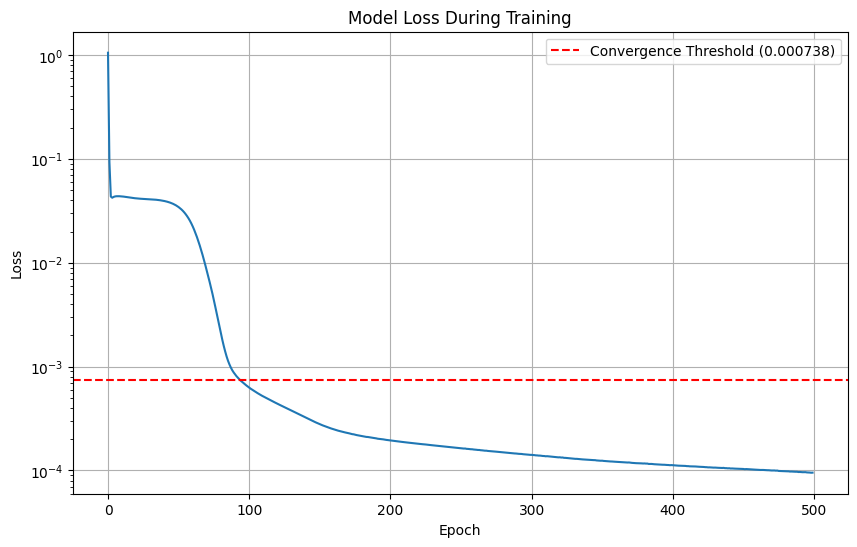

32/32 [==============================] - 0s 2ms/step


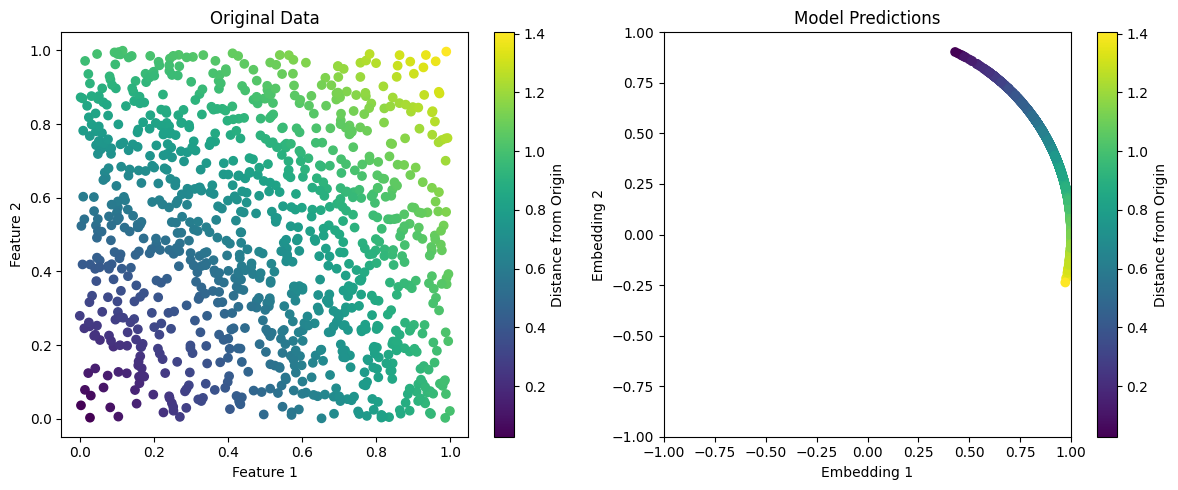

In [4]:
def custom_loss(y_true, y_pred):
    return mb.pds_sq_loss_vec(y_true, y_pred, pm)  # Replace with appropriate loss function

noise_level = 0.50
trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(
    loss_fn=custom_loss, 
    num_points=5000, 
    noise_level=noise_level,
    epochs=500, 
    batch_size=1024
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

Epoch 1/250
5/5 [==============================] - 1s 42ms/step - loss: 0.0217
Epoch 2/250
5/5 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 3/250
5/5 [==============================] - 0s 9ms/step - loss: 0.0070
Epoch 4/250
5/5 [==============================] - 0s 8ms/step - loss: 0.0050
Epoch 5/250
5/5 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 6/250
5/5 [==============================] - 0s 8ms/step - loss: 0.0017
Epoch 7/250
5/5 [==============================] - 0s 8ms/step - loss: 8.3670e-04
Epoch 8/250
5/5 [==============================] - 0s 8ms/step - loss: 5.6819e-04
Epoch 9/250
5/5 [==============================] - 0s 7ms/step - loss: 3.4744e-04
Epoch 10/250
5/5 [==============================] - 0s 8ms/step - loss: 2.2461e-04
Epoch 11/250
5/5 [==============================] - 0s 9ms/step - loss: 1.5362e-04
Epoch 12/250
5/5 [==============================] - 0s 8ms/step - loss: 1.1396e-04
Epoch 13/250
5/5 [==================

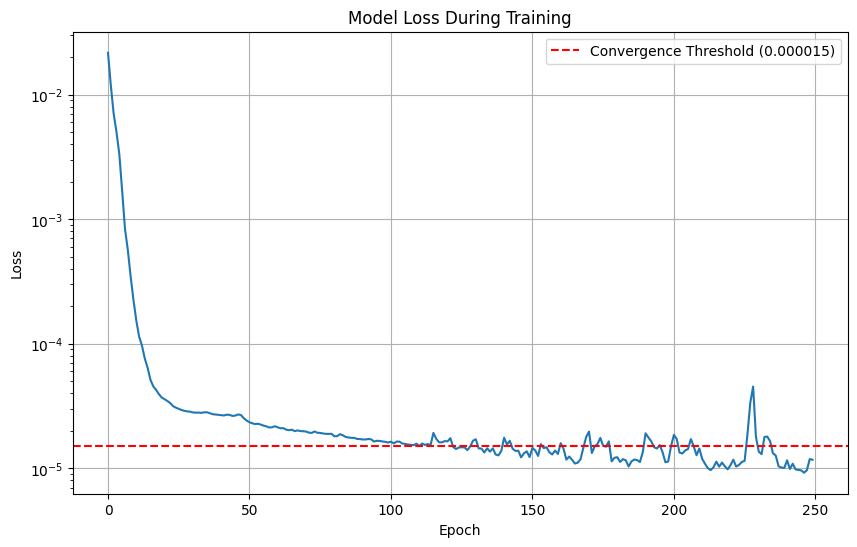

32/32 [==============================] - 0s 4ms/step


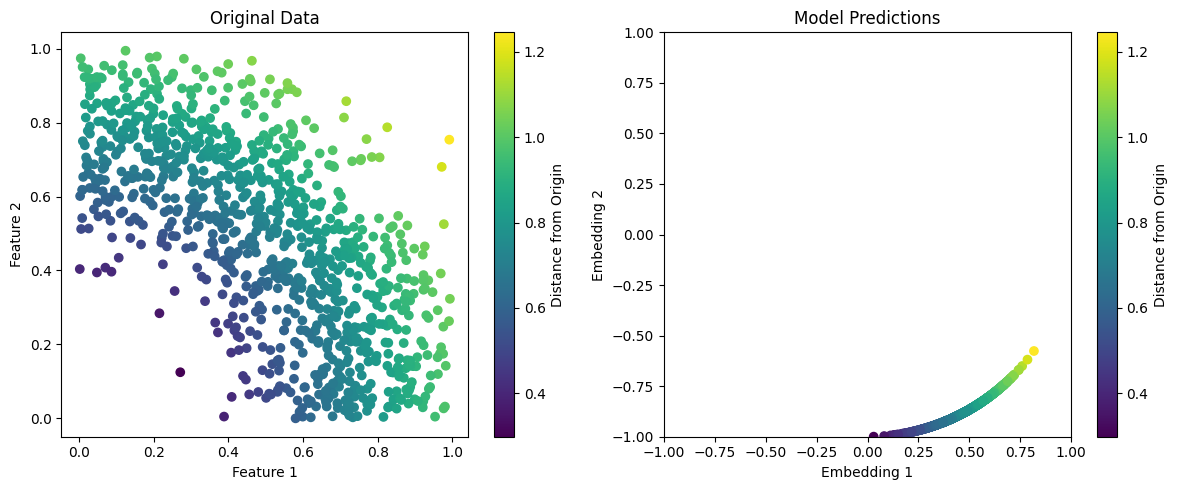

In [48]:
def custom_loss(y_true, y_pred):
    return mb.pds_loss_vec(y_true, y_pred, pm)  # Replace with appropriate loss function

noise_level = 0.15
trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(
    loss_fn=custom_loss, 
    num_points=5000, 
    noise_level=noise_level,
    epochs=250, 
    batch_size=1024
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

Epoch 1/250
5/5 [==============================] - 1s 7ms/step - loss: 0.2854
Epoch 2/250
5/5 [==============================] - 0s 7ms/step - loss: 0.0265
Epoch 3/250
5/5 [==============================] - 0s 6ms/step - loss: 0.0296
Epoch 4/250
5/5 [==============================] - 0s 6ms/step - loss: 0.0313
Epoch 5/250
5/5 [==============================] - 0s 6ms/step - loss: 0.0314
Epoch 6/250
5/5 [==============================] - 0s 6ms/step - loss: 0.0306
Epoch 7/250
5/5 [==============================] - 0s 6ms/step - loss: 0.0290
Epoch 8/250
5/5 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 9/250
5/5 [==============================] - 0s 7ms/step - loss: 0.0248
Epoch 10/250
5/5 [==============================] - 0s 7ms/step - loss: 0.0235
Epoch 11/250
5/5 [==============================] - 0s 7ms/step - loss: 0.0230
Epoch 12/250
5/5 [==============================] - 0s 10ms/step - loss: 0.0230
Epoch 13/250
5/5 [==============================] - 0s 7ms/s

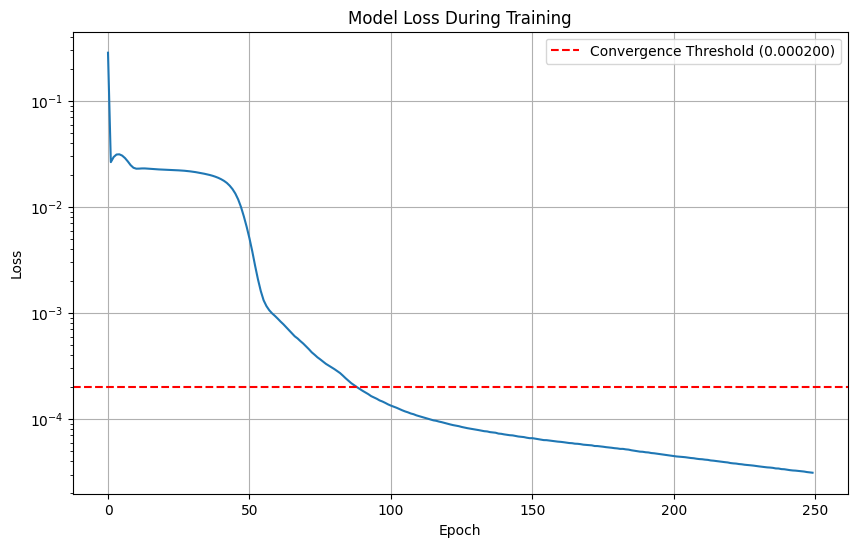

32/32 [==============================] - 0s 2ms/step


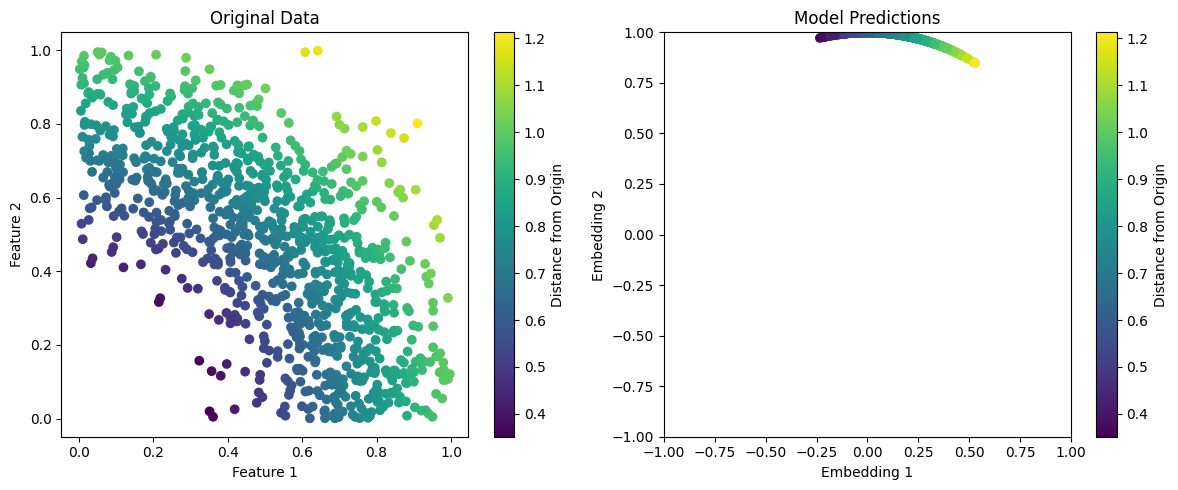

In [49]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pds_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function

noise_level = 0.15
trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(
    loss_fn=custom_loss, 
    num_points=5000,
    noise_level=noise_level, 
    epochs=250,
    batch_size=1024
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)


In [31]:
class TrainerV4_1:
    def __init__(self, input_dim=2, hidden_dims=None, output_dim=2):
        if hidden_dims is None:
            hidden_dims = [64, 32]
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()
        self.convergence_threshold = None

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers with Leaky ReLU activation
        for dim in self.hidden_dims:
            x = Dense(dim)(x)
            x = LeakyReLU()(x)

        # Representation output (normalized vector)
        representation_output = Dense(self.output_dim, name='representation_raw')(x)
        representation_output = NormalizeLayer(name='normalize_layer')(representation_output)
        
        # Distance prediction from representation
        distance_output = Dense(1, name='distance_prediction')(representation_output)
        
        model = Model(inputs=inputs, outputs=[distance_output, representation_output])
        return model

    def generate_synthetic_data(self, num_points=200, noise_level=0.15):
        """
        Generate synthetic data where:
        - Features are random 2D points with coordinates between 0 and 1
        - Labels are distances from origin (0,0)
        - Middle distances are ~10x more frequent than extremes
        - noise_level controls the spread of the gaussian weighting (default 0.15)
        """
        # Generate more points than needed for sampling
        pool_size = num_points * 10
        features = np.random.uniform(0, 1, (pool_size, self.input_dim))

        # Calculate distances
        distances = np.sqrt(np.sum(features ** 2, axis=1))

        # Create weights favoring middle distances
        # Use a gaussian centered at ~0.75 (middle of the possible range 0 to √2)
        weights = np.exp(-((distances - 0.75) ** 2) / (2 * noise_level ** 2))

        # Normalize weights to probabilities
        weights = weights / np.sum(weights)

        # Sample indices according to weights
        selected_indices = np.random.choice(
            pool_size,
            size=num_points,
            p=weights,
            replace=False
        )

        # Select the points
        selected_features = features[selected_indices]
        selected_distances = distances[selected_indices]

        return selected_features, selected_distances.reshape(-1, 1)

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions."""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, _ = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation

    def compute_distance_metrics(self, y_true, y_pred):
        """Compute evaluation metrics for distance prediction."""
        mse = tf.keras.losses.mse(y_true, y_pred).numpy().mean()
        mae = tf.keras.losses.mae(y_true, y_pred).numpy().mean()
        # R-squared and RMSE removed as per instructions
        return {
            'mse': mse,
            'mae': mae,
        }

    def train(
        self, 
        representation_loss_fn=None, 
        distance_loss_weight=1.0, 
        representation_loss_weight=0.5, 
        representation_targets=None, 
        num_points=2000, 
        epochs=1000, 
        batch_size=32, 
        noise_level=0.15, 
        verbose=1):
        """
        Train the model with dual outputs: distance prediction and representation learning.
        
        Args:
            representation_loss_fn: Loss function for representation learning. If None, uses features as targets (autoencoder style)
            distance_loss_weight: Weight for distance prediction loss
            representation_loss_weight: Weight for representation learning loss  
            representation_targets: Target for representation learning. If None, uses input features
            num_points: Number of training points
            epochs: Number of training epochs
            batch_size: Batch size
            noise_level: Noise level for data generation
            verbose: Verbosity level
        """
        # Generate synthetic data with specified noise level
        X_train, y_distance = self.generate_synthetic_data(num_points=num_points, noise_level=noise_level)
        
        # Set representation targets
        if representation_targets is None:
            y_representation = X_train  # Autoencoder style - reconstruct input features
        else:
            y_representation = representation_targets
            
        # Set representation loss function
        if representation_loss_fn is None:
            representation_loss_fn = 'mse'  # Default to MSE for autoencoder style

        # Compile model with multiple outputs and losses
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss={
                'distance_prediction': 'mse',
                'normalize_layer': representation_loss_fn
            },
            loss_weights={
                'distance_prediction': distance_loss_weight,
                'normalize_layer': representation_loss_weight
            },
            metrics={
                'distance_prediction': ['mae'],
                'normalize_layer': []
            }
        )

        # Prepare targets dictionary
        targets = {
            'distance_prediction': y_distance,
            'normalize_layer': y_representation
        }

        # Convert to tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, targets))
        train_dataset = train_dataset.batch(batch_size)

        # Initialize tracking variables
        start_time = time.time()
        batch_times = []
        convergence_epoch = None
        convergence_time = None

        class ConvergenceCallback(tf.keras.callbacks.Callback):
            def __init__(self, trainer, threshold_factor=0.0007):
                super().__init__()
                self.trainer = trainer
                self.threshold_factor = threshold_factor
                self.first_loss = None
                self.convergence_reached = False
                self.batch_start_time = None

            def on_train_begin(self, logs=None):
                self.batch_start_time = time.time()

            def on_batch_end(self, batch, logs=None):
                batch_end_time = time.time()
                batch_duration = batch_end_time - self.batch_start_time
                batch_times.append(batch_duration)
                self.batch_start_time = batch_end_time

            def on_epoch_end(self, epoch, logs=None):
                # Use total loss for convergence
                current_loss = logs['loss']

                if self.first_loss is None:
                    self.first_loss = current_loss
                    self.trainer.convergence_threshold = self.first_loss * self.threshold_factor

                if not self.convergence_reached and current_loss <= self.trainer.convergence_threshold:
                    self.convergence_reached = True
                    nonlocal convergence_epoch, convergence_time
                    convergence_epoch = epoch + 1
                    convergence_time = time.time() - start_time

        convergence_callback = ConvergenceCallback(self)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[
                IsTraining(self.phase_manager),
                convergence_callback
            ]
        )

        # Final predictions
        predictions = self.model.predict(X_train)
        distance_predictions = predictions[0]
        representation_predictions = predictions[1]

        # Compute evaluation metrics
        distance_metrics = self.compute_distance_metrics(y_distance, distance_predictions)
        correlation = self.compute_pairwise_correlation(X_train, representation_predictions)

        # Calculate and print metrics
        total_time = time.time() - start_time
        avg_batch_time = np.mean(batch_times)

        print("\nTraining Metrics:")
        print(f"Initial Total Loss: {history.history['loss'][0]:.6f}")
        print(f"Final Total Loss: {history.history['loss'][-1]:.6f}")
        print(f"Initial Distance Loss: {history.history['distance_prediction_loss'][0]:.6f}")
        print(f"Final Distance Loss: {history.history['distance_prediction_loss'][-1]:.6f}")
        print(f"Initial Representation Loss: {history.history['normalize_layer_loss'][0]:.6f}")
        print(f"Final Representation Loss: {history.history['normalize_layer_loss'][-1]:.6f}")
        print(f"Convergence Threshold: {self.convergence_threshold:.6f}")
        
        if convergence_epoch:
            print(f"Convergence Epoch: {convergence_epoch}")
            print(f"Loss at Convergence: {history.history['loss'][convergence_epoch - 1]:.6f}")
            print(f"Time to Convergence: {convergence_time:.2f} seconds")
        else:
            print("Model did not converge to threshold")
            
        print(f"Total Training Time: {total_time:.2f} seconds")
        print(f"Average Time per Batch: {avg_batch_time * 1000:.2f} ms")
        
        print("\nDistance Prediction Metrics:")
        print(f"MSE: {distance_metrics['mse']:.6f}")
        print(f"MAE: {distance_metrics['mae']:.6f}")
        
        print(f"\nRepresentation Quality:")
        print(f"Pairwise Correlation: {correlation:.4f}")
        print(f"Noise Level Used: {noise_level}")

        return history, distance_metrics, correlation, distance_predictions, representation_predictions, X_train, y_distance

    def plot_training_history(self, history):
        """Plot the training losses over epochs."""
        plt.figure(figsize=(15, 5))
        
        # Total loss
        plt.subplot(1, 3, 1)
        plt.plot(history.history['loss'])
        if self.convergence_threshold:
            plt.axhline(y=self.convergence_threshold, color='r', linestyle='--',
                        label=f'Convergence Threshold ({self.convergence_threshold:.6f})')
        plt.title('Total Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.grid(True)
        plt.legend()
        
        # Distance prediction loss
        plt.subplot(1, 3, 2)
        plt.plot(history.history['distance_prediction_loss'])
        plt.title('Distance Prediction Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.grid(True)
        
        # Representation loss
        plt.subplot(1, 3, 3)
        plt.plot(history.history['normalize_layer_loss'])
        plt.title('Representation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

    def plot_actual_vs_predicted(self, true_distances, predicted_distances):
        """Plot actual vs predicted distances with performance metrics."""
        plt.figure(figsize=(10, 8))
        
        # Main scatter plot
        plt.scatter(true_distances, predicted_distances, alpha=0.6, s=50)
        
        # Perfect prediction line
        min_dist = min(true_distances.min(), predicted_distances.min())
        max_dist = max(true_distances.max(), predicted_distances.max())
        plt.plot([min_dist, max_dist], [min_dist, max_dist], 'r--', linewidth=2, label='Perfect Prediction')
        
        # Calculate and display metrics
        residuals = true_distances.flatten() - predicted_distances.flatten()
        mse = np.mean(residuals**2)
        mae = np.mean(np.abs(residuals))
        
        # Add metrics to plot (no RMSE, no R²)
        metrics_text = f'MSE = {mse:.6f}\nMAE = {mae:.6f}'
        plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.xlabel('True Distance', fontsize=12)
        plt.ylabel('Predicted Distance', fontsize=12)
        plt.title('Distance Prediction: Actual vs Predicted', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Make plot square for better visualization
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    def plot_distance_predictions(self, features, true_distances, predicted_distances):
        """Plot comprehensive distance prediction analysis (reduced: no feature-by-predicted, no residuals, no R²/RMSE)."""
        plt.figure(figsize=(12, 4))
        
        # Actual vs Predicted scatter plot
        plt.subplot(1, 2, 1)
        plt.scatter(true_distances, predicted_distances, alpha=0.6)
        min_dist = min(true_distances.min(), predicted_distances.min())
        max_dist = max(true_distances.max(), predicted_distances.max())
        plt.plot([min_dist, max_dist], [min_dist, max_dist], 'r--', label='Perfect Prediction')
        
        # Calculate metrics
        residuals = true_distances.flatten() - predicted_distances.flatten()
        mse = np.mean(residuals**2)
        mae = np.mean(np.abs(residuals))
        metrics_text = f'MSE = {mse:.6f}\nMAE = {mae:.6f}'
        plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.xlabel('True Distance')
        plt.ylabel('Predicted Distance')
        plt.title('Distance Prediction: Actual vs Predicted')
        plt.legend()
        plt.grid(True)
        
        # Error distribution
        plt.subplot(1, 2, 2)
        plt.hist(residuals, bins=30, density=True, alpha=0.7, edgecolor='black')
        plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
        plt.axvline(x=np.mean(residuals), color='orange', linestyle='--', label=f'Mean Error: {np.mean(residuals):.4f}')
        plt.xlabel('Prediction Error')
        plt.ylabel('Density')
        plt.title('Error Distribution')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

    def plot_data_distribution(self, features, labels):
        """Plot the distribution of data points and their labels."""
        plt.figure(figsize=(15, 5))

        # Plot points in 2D space
        plt.subplot(1, 3, 1)
        scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Origin')
        plt.title('Data Points Colored by Distance')
        plt.xlabel('X')
        plt.ylabel('Y')

        # Plot distance distribution
        plt.subplot(1, 3, 2)
        plt.hist(labels, bins=30, density=True)

        # Add the target distribution curve
        x = np.linspace(0, np.sqrt(2), 100)
        target_dist = np.exp(-((x - 0.75) ** 2) / (2 * 0.15 ** 2))
        target_dist = target_dist / np.max(target_dist) * plt.gca().get_ylim()[1]
        plt.plot(x, target_dist, 'r--', label='Target Distribution')
        plt.legend()

        plt.title('Distribution of Distances')
        plt.xlabel('Distance from Origin')
        plt.ylabel('Density')

        # Plot points with reference circles
        plt.subplot(1, 3, 3)
        plt.scatter(features[:, 0], features[:, 1], alpha=0.5)

        # Add quarter circles at different radii
        for radius in [0.25, 0.5, 0.75, 1.0]:
            circle = plt.Circle((0, 0), radius, fill=False, color='red', alpha=0.3)
            plt.gca().add_artist(circle)

        plt.axis('equal')
        plt.title('Points with Reference Circles')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, features, labels, distance_predictions, representation_predictions):
        """Plot original data and representations with actual vs predicted. 
        No feature colored by predicted distance, no residual plot, no RMSE/R²."""
        plt.figure(figsize=(16, 8))

        # Actual vs Predicted (prominent first plot)
        plt.subplot(2, 2, 1)
        plt.scatter(labels, distance_predictions, alpha=0.6, s=50)
        min_dist = min(labels.min(), distance_predictions.min())
        max_dist = max(labels.max(), distance_predictions.max())
        plt.plot([min_dist, max_dist], [min_dist, max_dist], 'r--', linewidth=2, label='Perfect Prediction')
        
        # Calculate metrics
        residuals = labels.flatten() - distance_predictions.flatten()
        mse = np.mean(residuals**2)
        mae = np.mean(np.abs(residuals))
        metrics_text = f'MSE = {mse:.6f}\nMAE = {mae:.6f}'
        plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontsize=12, fontweight='bold')
        
        plt.xlabel('True Distance', fontsize=12)
        plt.ylabel('Predicted Distance', fontsize=12)
        plt.title('Distance Prediction: Actual vs Predicted', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Original data
        plt.subplot(2, 2, 2)
        plt.scatter(features[:, 0], features[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='True Distance')
        plt.title('Original Data')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        # Representation space
        plt.subplot(2, 2, 3)
        plt.scatter(representation_predictions[:, 0], representation_predictions[:, 1], 
                   c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='True Distance')
        plt.title('Learned Representation Space')
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        
        # Error distribution
        plt.subplot(2, 2, 4)
        plt.hist(residuals, bins=30, density=True, alpha=0.7, edgecolor='black')
        plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
        plt.axvline(x=np.mean(residuals), color='orange', linestyle='--', 
                   label=f'Mean Error: {np.mean(residuals):.4f}')
        plt.xlabel('Prediction Error')
        plt.ylabel('Density')
        plt.title('Error Distribution')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

Epoch 1/450


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - distance_prediction_loss: 0.3445 - distance_prediction_mae: 0.5109 - loss: 1.3676 - normalize_layer_loss: 1.0220 
Epoch 2/450
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - distance_prediction_loss: 0.0940 - distance_prediction_mae: 0.2538 - loss: 1.1108 - normalize_layer_loss: 1.0168 
Epoch 3/450
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - distance_prediction_loss: 0.0858 - distance_prediction_mae: 0.2422 - loss: 1.1079 - normalize_layer_loss: 1.0221 
Epoch 4/450
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - distance_prediction_loss: 0.0854 - distance_prediction_mae: 0.2414 - loss: 1.1018 - normalize_layer_loss: 1.0164 
Epoch 5/450
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - distance_prediction_loss: 0.0805 - distance_prediction_mae: 0.2316 - loss: 1.0773 - normalize_layer_loss: 0.9966 
Epoch 6/450
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - distance_prediction_loss: 0.0729 - distance_prediction_mae: 0.2218 - loss: 0.9903 - normalize_layer_loss: 0.9165 
Epoch 7/450
5/5 ━━━━━

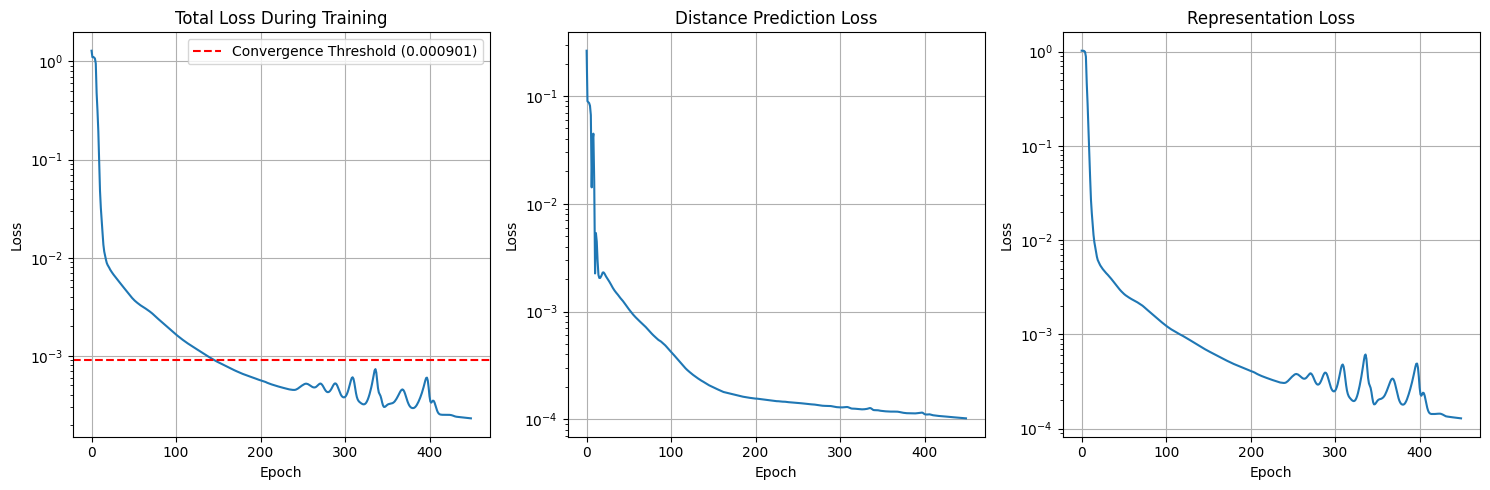

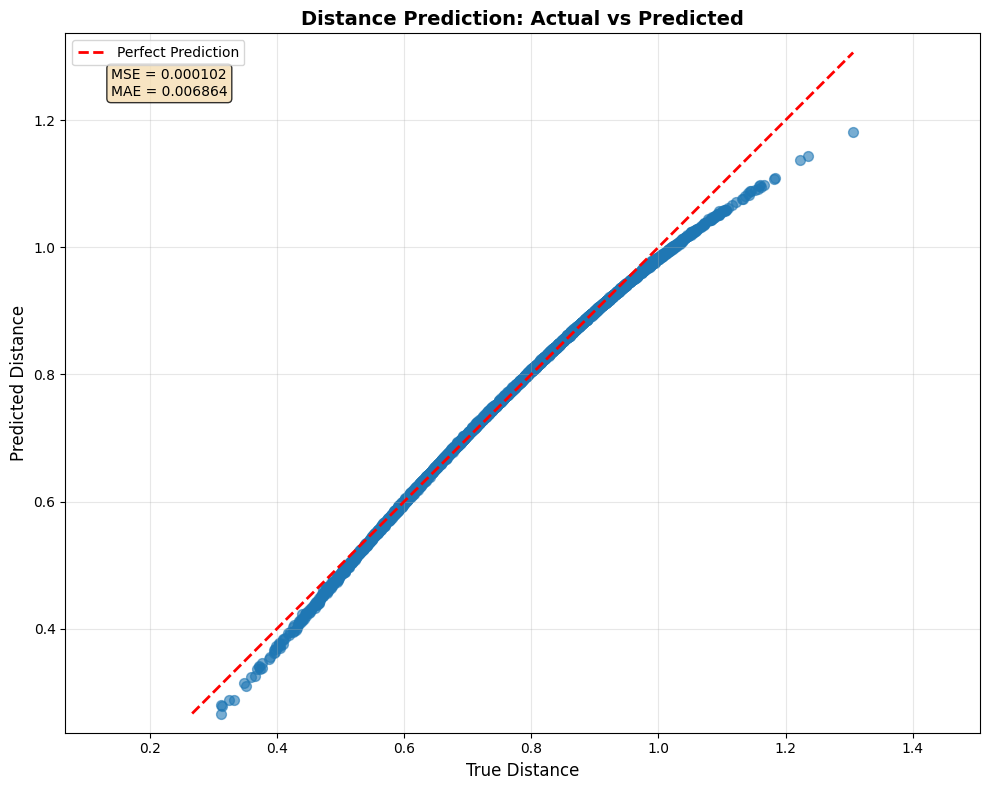

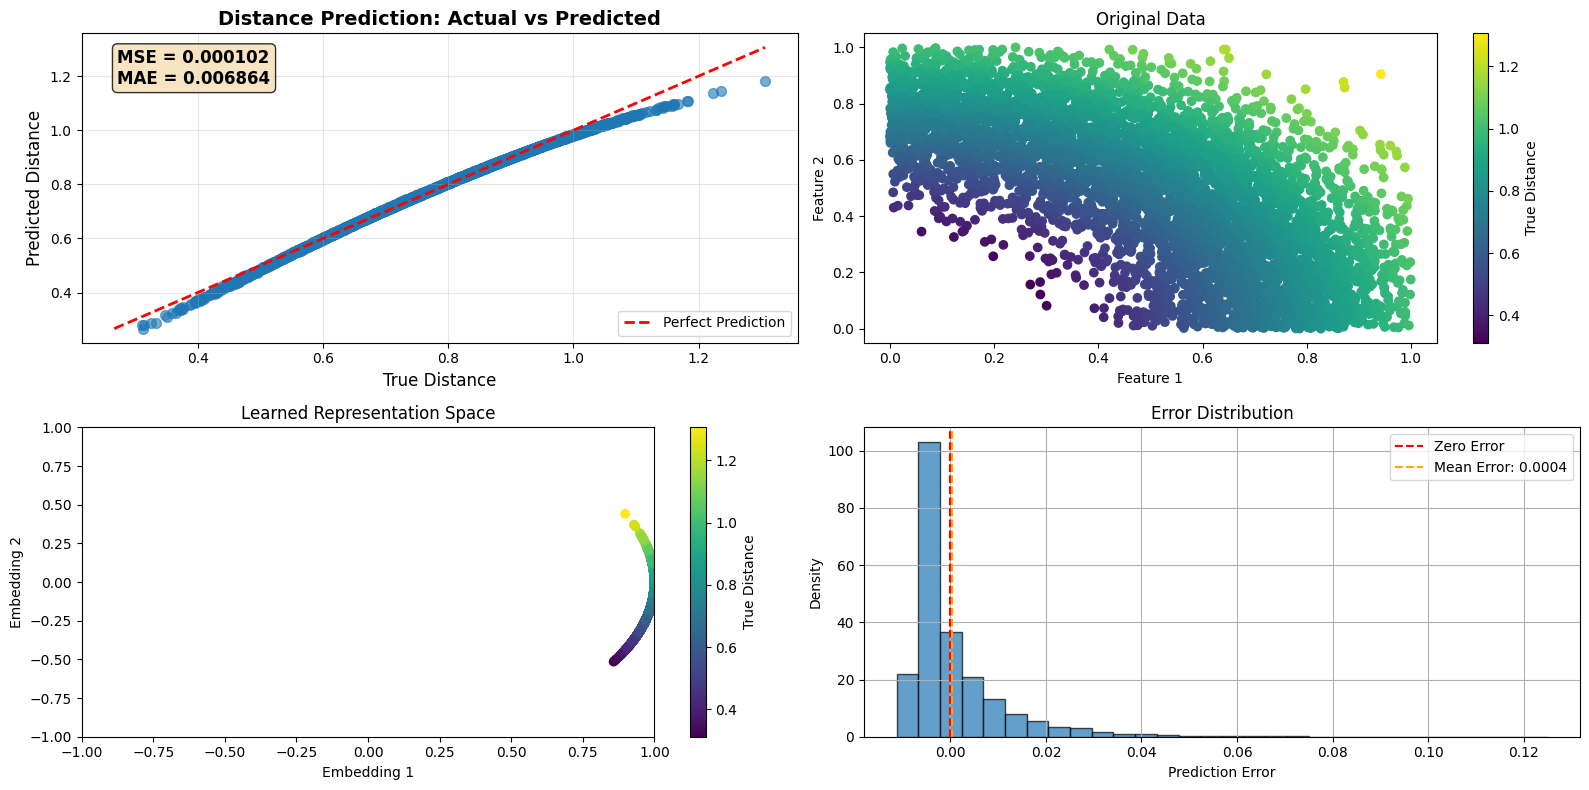

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step

Test Set Performance:
Test Pairwise Correlation: 0.1529
Test Distance Prediction MAE: 0.007033


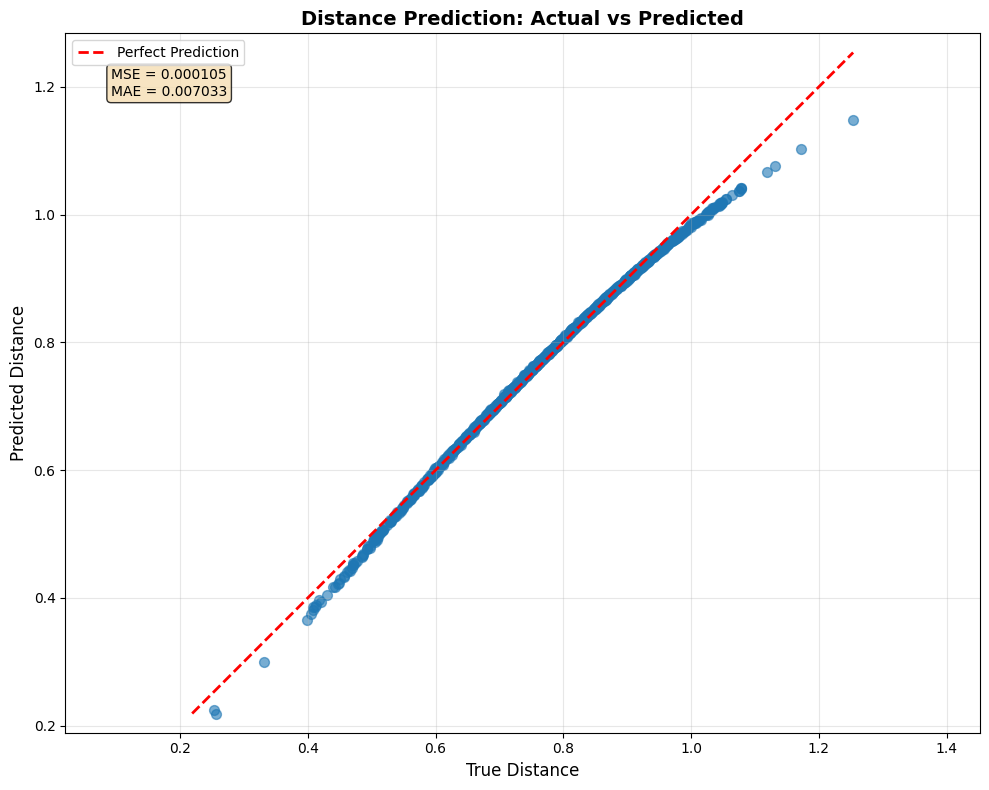

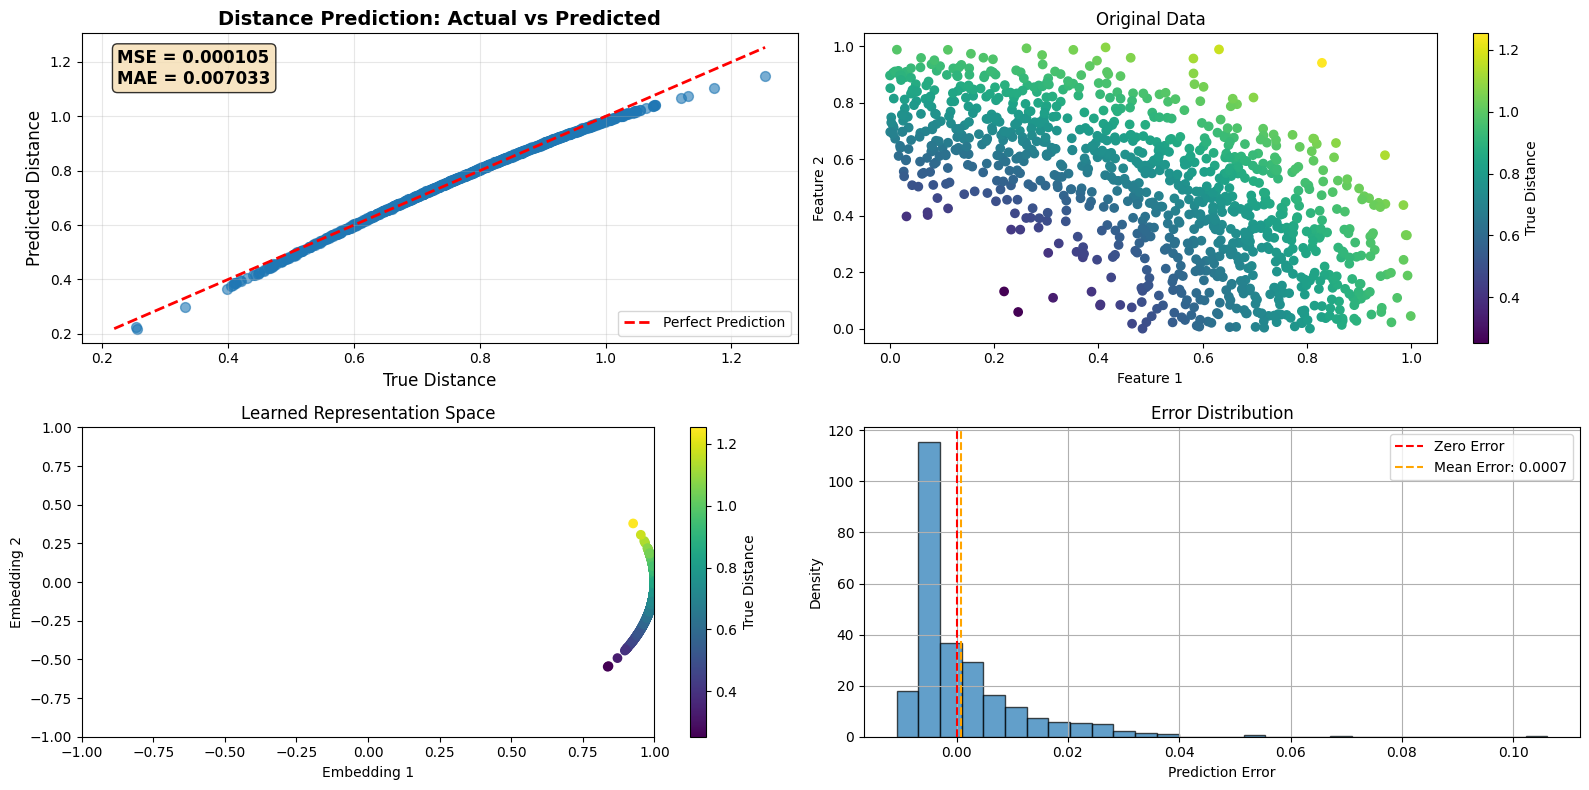

In [33]:
def custom_loss_wrapper(y_true, y_pred):
    """
    Wrapper for PDC loss that handles the representation learning task.
    This should be used when applying PDC loss to representations.
    """
    # The PDC loss expects labels to be [batch_size, 1], but we're using it for 
    # representation learning where y_true are the input features [batch_size, 2]
    # We need to compute distances from the input features to use as labels
    
    # Compute distances from origin for each point in y_true (which are the input features)
    distances = tf.sqrt(tf.reduce_sum(tf.square(y_true), axis=1, keepdims=True))
    
    # Now apply PDC loss with proper shapes
    return mb.pdc_loss_vec(distances, y_pred, pm)

def distance_custom_loss(y_true, y_pred):
    """
    Custom loss for distance prediction task.
    y_true: true distances [batch_size, 1]
    y_pred: predicted distances [batch_size, 1]
    """
    # For distance prediction, we might want to use PDC loss as well
    # or just stick with MSE
    return tf.keras.losses.mse(y_true, y_pred)

noise_level = 0.15
trainer = TrainerV4_1(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)

# Option 1: Use PDC loss for representation learning (recommended)
history, distance_metrics, correlation, distance_predictions, representation_predictions, X_train, y_distance = trainer.train(
    representation_loss_fn=custom_loss_wrapper,  # PDC loss for representation learning
    distance_loss_weight=1.0,                    # Standard MSE for distance prediction
    representation_loss_weight=1.0,              # PDC loss for representation learning
    num_points=5000, 
    noise_level=noise_level, 
    epochs=450, 
    batch_size=1024
)

# Print results with new metrics
print(f"Final Pairwise Correlation: {correlation:.4f}")
print(f"Distance Prediction MAE: {distance_metrics['mae']:.6f}")

# Plot training history (now shows both losses)
trainer.plot_training_history(history)

# Plot the main actual vs predicted plot
trainer.plot_actual_vs_predicted(y_distance, distance_predictions)

# Plot comprehensive analysis including actual vs predicted
trainer.plot_predictions(X_train, y_distance, distance_predictions, representation_predictions)

# Generate test data and evaluate
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
test_predictions = trainer.model.predict(X_test)
test_distance_predictions = test_predictions[0]
test_representation_predictions = test_predictions[1]

# Evaluate on test data
test_distance_metrics = trainer.compute_distance_metrics(y_test, test_distance_predictions)
test_correlation = trainer.compute_pairwise_correlation(X_test, test_representation_predictions)

print(f"\nTest Set Performance:")
print(f"Test Pairwise Correlation: {test_correlation:.4f}")
print(f"Test Distance Prediction MAE: {test_distance_metrics['mae']:.6f}")

# Plot test results
trainer.plot_actual_vs_predicted(y_test, test_distance_predictions)
trainer.plot_predictions(X_test, y_test, test_distance_predictions, test_representation_predictions)

Epoch 1/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0003  
Epoch 2/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9474 
Epoch 3/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8890
Epoch 4/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7620
Epoch 5/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2573
Epoch 6/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1125
Epoch 7/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0646
Epoch 8/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0363
Epoch 9/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0243
Epoch 10/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0232
Epoch 11/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0194
Epoch 12/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0170
Epoch 13/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144
Epoch 14/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124
Epoch 15/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108
Epoch 16/250
5/5 ━━━━━━━━━━━━━━

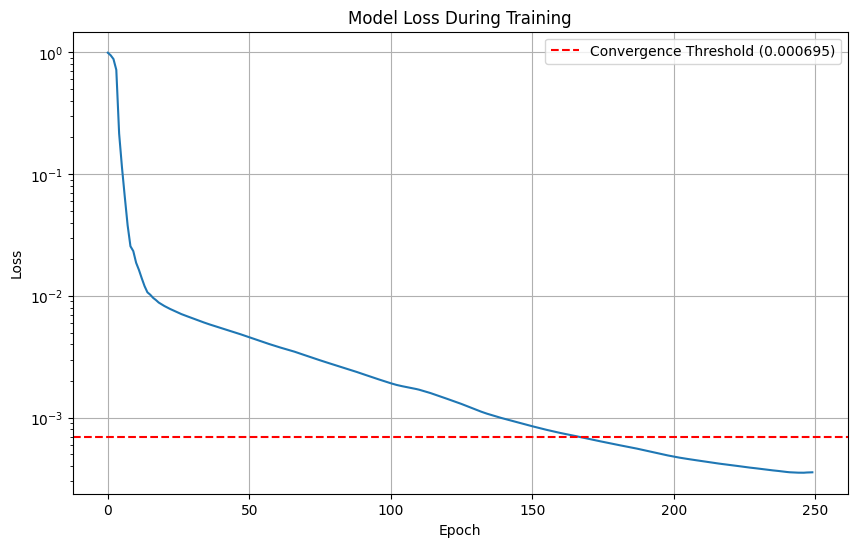

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step


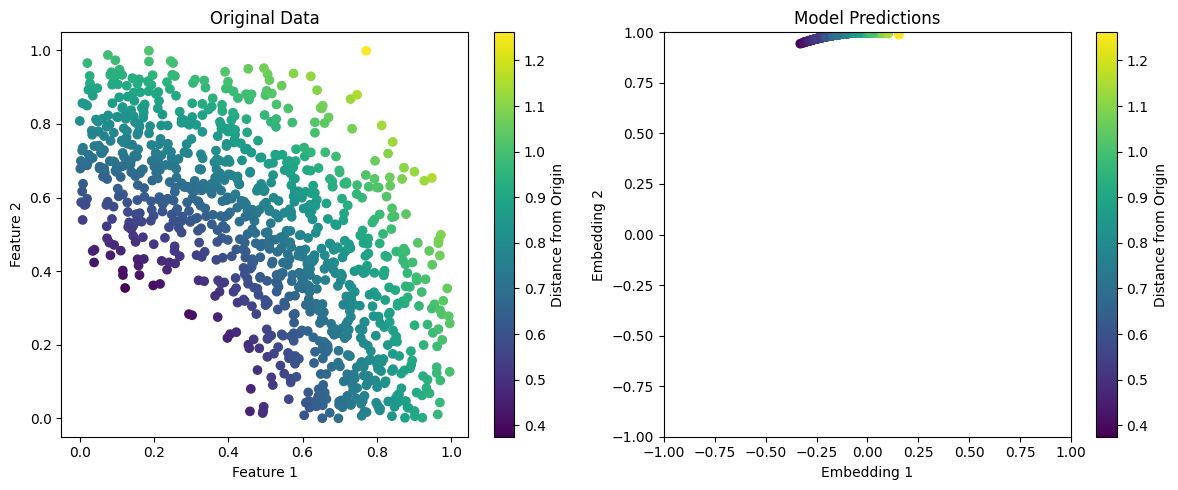

In [ ]:
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


noise_level = 0.15
trainer = TrainerV4_1(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(
    loss_fn=custom_loss,
    num_points=5000, 
    noise_level=noise_level, 
    epochs=250, batch_size=1024
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

Epoch 1/250
5/5 [==============================] - 2s 10ms/step - loss: 0.6825
Epoch 2/250
5/5 [==============================] - 0s 8ms/step - loss: 0.2234
Epoch 3/250
5/5 [==============================] - 0s 10ms/step - loss: 0.1244
Epoch 4/250
5/5 [==============================] - 0s 11ms/step - loss: 0.0606
Epoch 5/250
5/5 [==============================] - 0s 11ms/step - loss: 0.0462
Epoch 6/250
5/5 [==============================] - 0s 9ms/step - loss: 0.0237
Epoch 7/250
5/5 [==============================] - 0s 8ms/step - loss: 0.0162
Epoch 8/250
5/5 [==============================] - 0s 9ms/step - loss: 0.0143
Epoch 9/250
5/5 [==============================] - 0s 10ms/step - loss: 0.0105
Epoch 10/250
5/5 [==============================] - 0s 9ms/step - loss: 0.0106
Epoch 11/250
5/5 [==============================] - 0s 10ms/step - loss: 0.0083
Epoch 12/250
5/5 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 13/250
5/5 [==============================] - 0s 

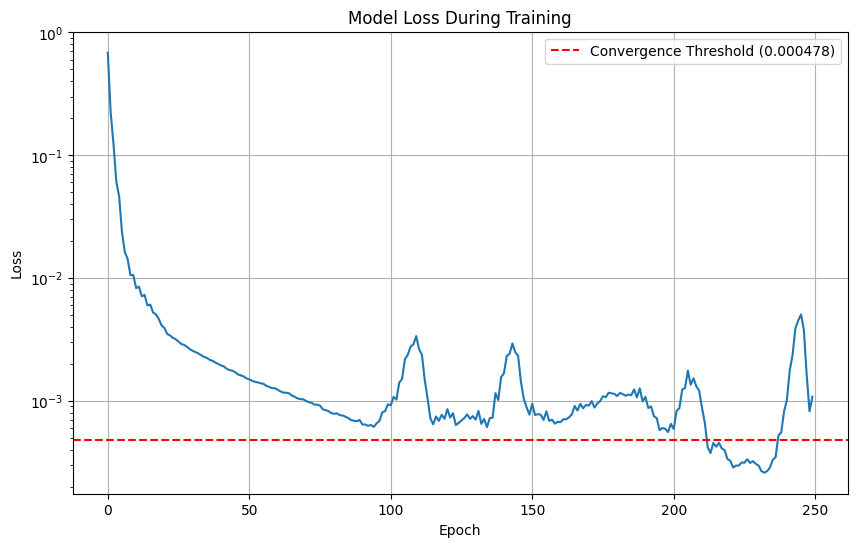

32/32 [==============================] - 0s 2ms/step


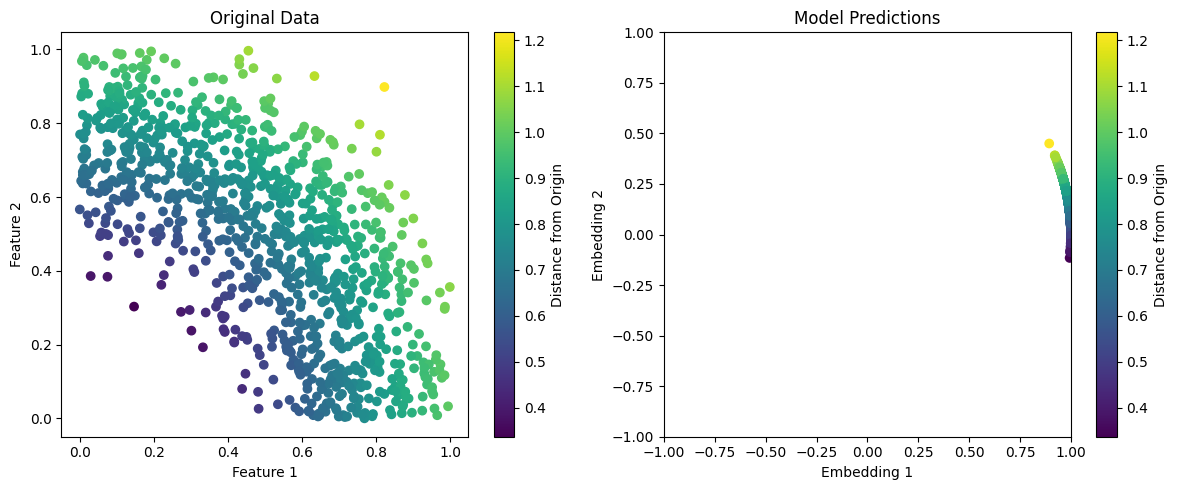

In [24]:

def custom_loss(y_true, y_pred):
    return mb.pdc_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


noise_level = 0.15
trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(
    loss_fn=custom_loss,
    num_points=5000,
    noise_level=noise_level,
    epochs=250, batch_size=1024
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

Epoch 1/250
5/5 [==============================] - 1s 6ms/step - loss: 0.4505
Epoch 2/250
5/5 [==============================] - 0s 8ms/step - loss: 0.0241
Epoch 3/250
5/5 [==============================] - 0s 6ms/step - loss: 0.0244
Epoch 4/250
5/5 [==============================] - 0s 7ms/step - loss: 0.0250
Epoch 5/250
5/5 [==============================] - 0s 7ms/step - loss: 0.0251
Epoch 6/250
5/5 [==============================] - 0s 7ms/step - loss: 0.0252
Epoch 7/250
5/5 [==============================] - 0s 6ms/step - loss: 0.0252
Epoch 8/250
5/5 [==============================] - 0s 6ms/step - loss: 0.0251
Epoch 9/250
5/5 [==============================] - 0s 7ms/step - loss: 0.0250
Epoch 10/250
5/5 [==============================] - 0s 6ms/step - loss: 0.0249
Epoch 11/250
5/5 [==============================] - 0s 6ms/step - loss: 0.0248
Epoch 12/250
5/5 [==============================] - 0s 7ms/step - loss: 0.0247
Epoch 13/250
5/5 [==============================] - 0s 6ms/st

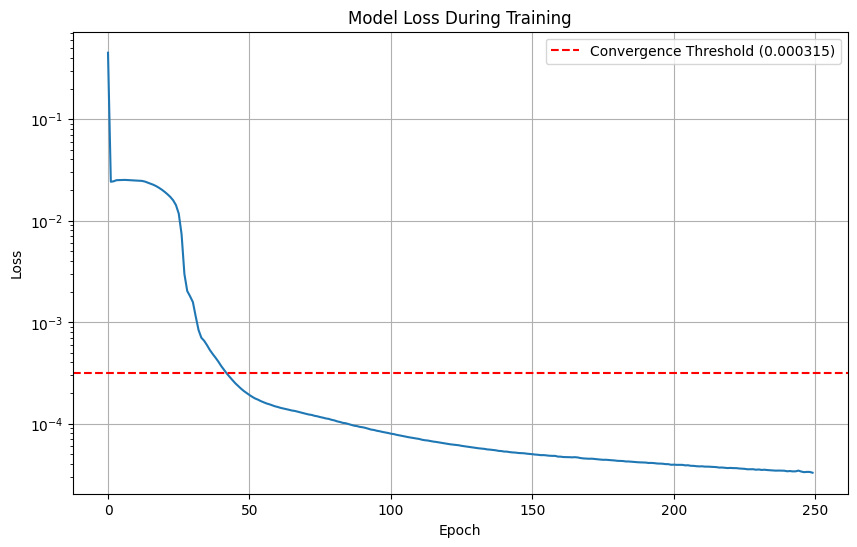

32/32 [==============================] - 0s 3ms/step


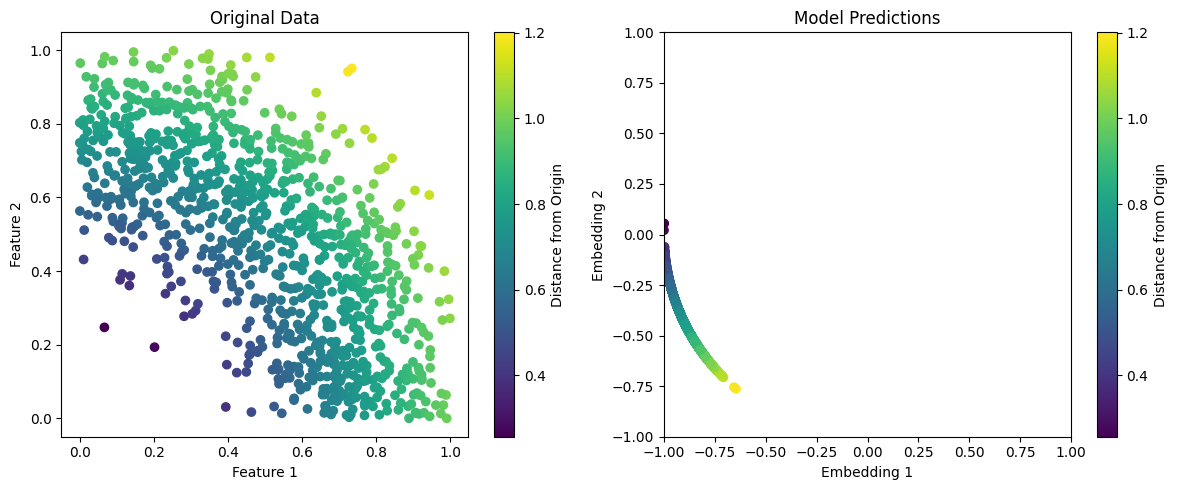

In [35]:
def custom_loss(y_true, y_pred):
    return mb.pds_loss_linear_m_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


noise_level = 0.15
trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(
    loss_fn=custom_loss,
    num_points=5000,
    noise_level=noise_level,
    epochs=250, batch_size=1024
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

Epoch 1/250
5/5 [==============================] - 1s 7ms/step - loss: 0.9665
Epoch 2/250
5/5 [==============================] - 0s 8ms/step - loss: 0.9313
Epoch 3/250
5/5 [==============================] - 0s 8ms/step - loss: 0.8989
Epoch 4/250
5/5 [==============================] - 0s 9ms/step - loss: 0.8240
Epoch 5/250
5/5 [==============================] - 0s 9ms/step - loss: 0.5528
Epoch 6/250
5/5 [==============================] - 0s 7ms/step - loss: 0.2978
Epoch 7/250
5/5 [==============================] - 0s 7ms/step - loss: 0.1581
Epoch 8/250
5/5 [==============================] - 0s 8ms/step - loss: 0.0927
Epoch 9/250
5/5 [==============================] - 0s 7ms/step - loss: 0.0566
Epoch 10/250
5/5 [==============================] - 0s 8ms/step - loss: 0.0378
Epoch 11/250
5/5 [==============================] - 0s 7ms/step - loss: 0.0302
Epoch 12/250
5/5 [==============================] - 0s 7ms/step - loss: 0.0226
Epoch 13/250
5/5 [==============================] - 0s 7ms/st

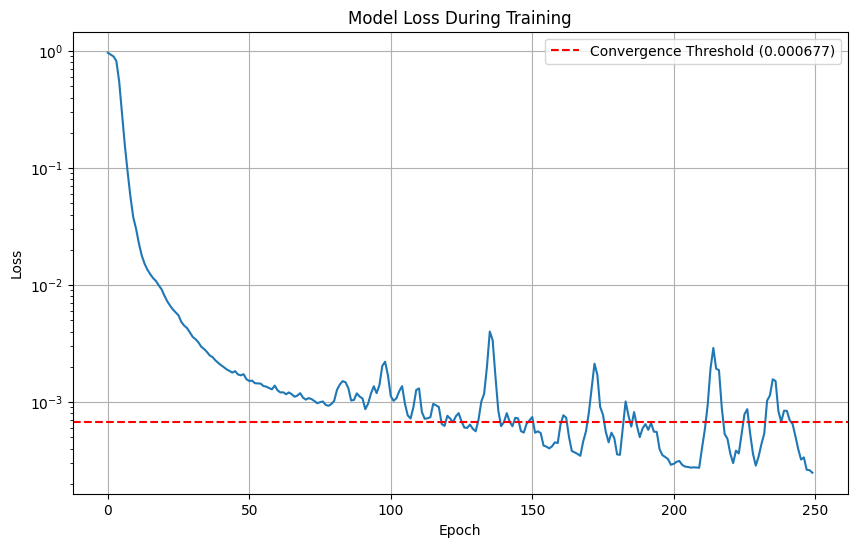

32/32 [==============================] - 0s 4ms/step


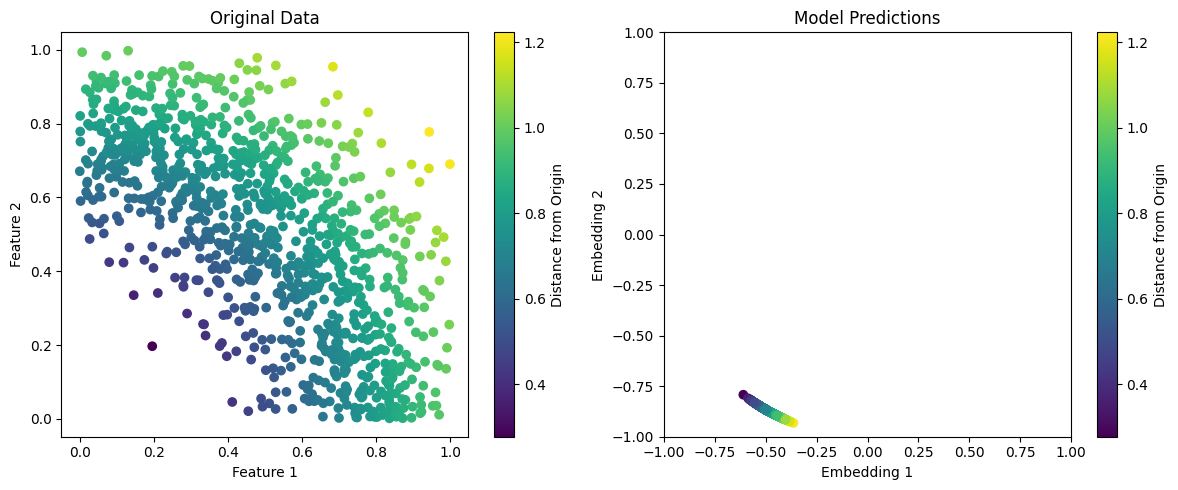

In [21]:
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_linear_m_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


noise_level = 0.15
trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(
    loss_fn=custom_loss,
    num_points=5000,
    noise_level=noise_level,
    epochs=250, batch_size=1024
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

In [20]:
class TrainerV5:
    def __init__(self, input_dim=2, hidden_dims=None, output_dim=2, ae=False):
        if hidden_dims is None:
            hidden_dims = [64, 32]
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.ae = ae
        self.encoder_model = None
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()
        self.convergence_threshold = None

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers with Leaky ReLU activation
        for dim in self.hidden_dims:
            x = Dense(dim)(x)
            x = LeakyReLU()(x)

        # Output layer (Encoder output)
        outputs = Dense(self.output_dim)(x)
        outputs = NormalizeLayer(name='normalize_layer')(outputs)

        if not self.ae:
            model = Model(inputs=inputs, outputs=outputs)
            self.encoder_model = model
        else:
            # Build decoder
            decoder_x = outputs
            for dim in reversed(self.hidden_dims):
                decoder_x = Dense(dim)(decoder_x)
                decoder_x = LeakyReLU()(decoder_x)
            reconstructed = Dense(self.input_dim)(decoder_x)
            model = Model(inputs=inputs, outputs=[outputs, reconstructed])
            self.encoder_model = Model(inputs=inputs, outputs=outputs)

        return model

    def generate_synthetic_data(self, num_points=200):
        """
        Generate synthetic data where:
        - Features are random 2D points with coordinates between 0 and 1
        - Labels are distances from origin (0,0)
        - Middle distances are ~10x more frequent than extremes
        """
        # Generate more points than needed for sampling
        pool_size = num_points * 10
        features = np.random.uniform(0, 1, (pool_size, self.input_dim))

        # Calculate distances
        distances = np.sqrt(np.sum(features ** 2, axis=1))

        # Create weights favoring middle distances
        # Use a gaussian centered at ~0.75 (middle of the possible range 0 to √2)
        weights = np.exp(-((distances - 0.75) ** 2) / (2 * 0.15 ** 2))

        # Normalize weights to probabilities
        weights = weights / np.sum(weights)

        # Sample indices according to weights
        selected_indices = np.random.choice(
            pool_size,
            size=num_points,
            p=weights,
            replace=False
        )

        # Select the points
        selected_features = features[selected_indices]
        selected_distances = distances[selected_indices]

        return selected_features, selected_distances.reshape(-1, 1)

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions."""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, _ = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation

    def train(self, loss_fn, num_points=2000, epochs=1000, batch_size=32, verbose=1, lambda_value=1.0):
        # Generate synthetic data
        X_train, y_train = self.generate_synthetic_data(num_points=num_points)

        # Adjust targets for AE
        if self.ae:
            train_targets = (y_train, X_train)
        else:
            train_targets = y_train

        # Compile model
        if not self.ae:
            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=loss_fn
            )
        else:
            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=[loss_fn, 'mse'],
                loss_weights=[1.0, lambda_value]
            )

        # Convert to tf.data.Dataset
        if not self.ae:
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        else:
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, (y_train, X_train)))
        train_dataset = train_dataset.batch(batch_size)

        # Initialize tracking variables
        start_time = time.time()
        batch_times = []
        convergence_epoch = None
        convergence_time = None

        class ConvergenceCallback(tf.keras.callbacks.Callback):
            def __init__(self, trainer, threshold_factor=0.0007):
                super().__init__()
                self.trainer = trainer
                self.threshold_factor = threshold_factor
                self.first_loss = None
                self.convergence_reached = False
                self.batch_start_time = None

            def on_train_begin(self, logs=None):
                self.batch_start_time = time.time()

            def on_batch_end(self, batch, logs=None):
                batch_end_time = time.time()
                batch_duration = batch_end_time - self.batch_start_time
                batch_times.append(batch_duration)
                self.batch_start_time = batch_end_time

            def on_epoch_end(self, epoch, logs=None):
                current_loss = logs['loss']

                if self.first_loss is None:
                    self.first_loss = current_loss
                    self.trainer.convergence_threshold = self.first_loss * self.threshold_factor

                if not self.convergence_reached and current_loss <= self.trainer.convergence_threshold:
                    self.convergence_reached = True
                    nonlocal convergence_epoch, convergence_time
                    convergence_epoch = epoch + 1
                    convergence_time = time.time() - start_time

        convergence_callback = ConvergenceCallback(self)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[
                IsTraining(self.phase_manager),
                convergence_callback
            ]
        )

        # Final predictions using the encoder model
        predictions = self.encoder_model.predict(X_train)

        # Compute final correlation
        correlation = self.compute_pairwise_correlation(X_train, predictions)

        # Calculate and print metrics
        total_time = time.time() - start_time
        avg_batch_time = np.mean(batch_times)

        print("\nTraining Metrics:")
        print(f"Initial Loss: {history.history['loss'][0]:.6f}")
        print(f"Final Loss: {history.history['loss'][-1]:.6f}")
        print(f"Convergence Threshold: {self.convergence_threshold:.6f}")
        if convergence_epoch:
            print(f"Convergence Epoch: {convergence_epoch}")
            print(f"Loss at Convergence: {history.history['loss'][convergence_epoch - 1]:.6f}")
            print(f"Time to Convergence: {convergence_time:.2f} seconds")
        else:
            print("Model did not converge to threshold")
        print(f"Total Training Time: {total_time:.2f} seconds")
        print(f"Average Time per Batch: {avg_batch_time * 1000:.2f} ms")
        print(f"Final Correlation: {correlation:.4f}")

        return history, correlation

    def plot_training_history(self, history):
        """Plot the training loss over epochs."""
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.axhline(y=self.convergence_threshold, color='r', linestyle='--',
                    label=f'Convergence Threshold ({self.convergence_threshold:.6f})')
        plt.title('Model Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  # Use log scale to better see convergence
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_data_distribution(self, features, labels):
        """Plot the distribution of data points and their labels."""
        plt.figure(figsize=(15, 5))

        # Plot points in 2D space
        plt.subplot(1, 3, 1)
        scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Origin')
        plt.title('Data Points Colored by Distance')
        plt.xlabel('X')
        plt.ylabel('Y')

        # Plot distance distribution
        plt.subplot(1, 3, 2)
        plt.hist(labels, bins=30, density=True)

        # Add the target distribution curve
        x = np.linspace(0, np.sqrt(2), 100)
        target_dist = np.exp(-((x - 0.75) ** 2) / (2 * 0.15 ** 2))
        target_dist = target_dist / np.max(target_dist) * plt.gca().get_ylim()[1]
        plt.plot(x, target_dist, 'r--', label='Target Distribution')
        plt.legend()

        plt.title('Distribution of Distances')
        plt.xlabel('Distance from Origin')
        plt.ylabel('Density')

        # Plot points with reference circles
        plt.subplot(1, 3, 3)
        plt.scatter(features[:, 0], features[:, 1], alpha=0.5)

        # Add quarter circles at different radii
        for radius in [0.25, 0.5, 0.75, 1.0]:
            circle = plt.Circle((0, 0), radius, fill=False, color='red', alpha=0.3)
            plt.gca().add_artist(circle)

        plt.axis('equal')
        plt.title('Points with Reference Circles')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, features, labels, predictions):
        """Plot original data and model predictions."""
        plt.figure(figsize=(12, 5))

        # Original data
        plt.subplot(1, 2, 1)
        plt.scatter(features[:, 0], features[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Original Data')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        # Predictions
        plt.subplot(1, 2, 2)
        plt.scatter(predictions[:, 0], predictions[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Model Predictions')
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.tight_layout()
        plt.show()


Epoch 1/500
5/5 [==============================] - 1s 16ms/step - loss: 1.2612 - normalize_layer_loss: 1.0205 - dense_29_loss: 0.2407
Epoch 2/500
5/5 [==============================] - 0s 14ms/step - loss: 0.8763 - normalize_layer_loss: 0.6764 - dense_29_loss: 0.1999
Epoch 3/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4499 - normalize_layer_loss: 0.2443 - dense_29_loss: 0.2056
Epoch 4/500
5/5 [==============================] - 0s 16ms/step - loss: 0.2954 - normalize_layer_loss: 0.1400 - dense_29_loss: 0.1555
Epoch 5/500
5/5 [==============================] - 0s 18ms/step - loss: 0.2004 - normalize_layer_loss: 0.0831 - dense_29_loss: 0.1173
Epoch 6/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1262 - normalize_layer_loss: 0.0378 - dense_29_loss: 0.0884
Epoch 7/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1009 - normalize_layer_loss: 0.0333 - dense_29_loss: 0.0676
Epoch 8/500
5/5 [==============================] - 0s 19ms/ste

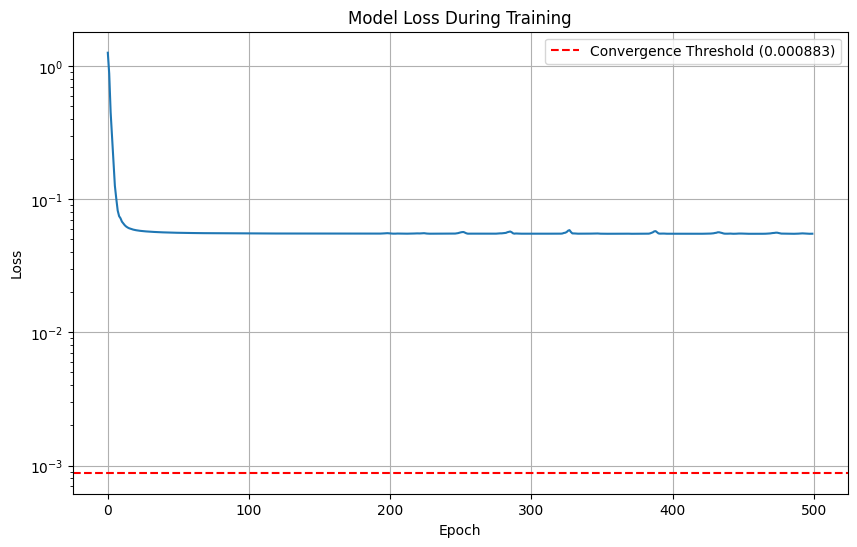

32/32 [==============================] - 0s 2ms/step


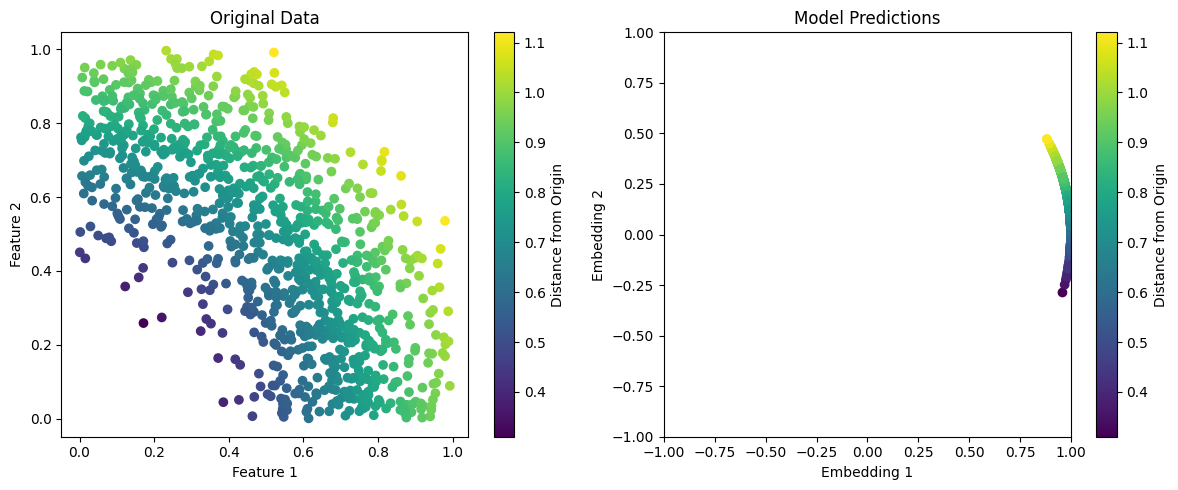

In [22]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


# Instantiate TrainerV5 with autoencoder enabled
trainer = TrainerV5(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2, ae=True)

# Train the model
history, final_correlation = trainer.train(
    loss_fn=custom_loss,
    num_points=5000,
    epochs=500,
    batch_size=1024
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Generate synthetic data for testing
X_test, y_test = trainer.generate_synthetic_data(num_points=1000)

# Use the encoder model to get the embeddings
predictions = trainer.encoder_model.predict(X_test)

# Plot predictions
trainer.plot_predictions(X_test, y_test, predictions)


In [ ]:
import time
import numpy as np

# Define your custom loss function
def custom_loss(y_true, y_pred):
    return mb.pds_sq_loss_vec(y_true, y_pred, pm)  # Replace with your actual loss function

noise_level = 0.15
N = 5  # Number of trials

# Initialize lists to store metrics
epochs_to_converge_list = []
time_to_converge_list = []
loss_at_convergence_list = []
time_per_epoch_list = []
final_correlation_list = []

# Convergence criteria settings
convergence_criterion = 1e-4  # Threshold for change in loss
patience = 5  # Number of consecutive epochs to check for convergence

for trial in range(N):
    print(f"Starting trial {trial + 1}/{N}")
    
    # Instantiate the trainer
    trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
    
    # Generate synthetic data (if needed within the trainer)
    # X_train, y_train = trainer.generate_synthetic_data(num_points=5000, noise_level=noise_level)
    
    # Start timer
    start_time = time.perf_counter()
    
    # Train the model
    history, final_correlation = trainer.train(
        loss_fn=custom_loss,
        num_points=5000,
        noise_level=noise_level,
        epochs=500,
        batch_size=1024
    )
    
    # End timer
    end_time = time.perf_counter()
    total_time = end_time - start_time
    
    # Calculate time per epoch
    num_epochs = len(history.history['loss'])
    time_per_epoch = total_time / num_epochs
    
    # Determine epochs to converge and loss at convergence
    losses = history.history['loss']
    epochs_to_converge = num_epochs  # Default to total epochs if convergence not detected
    convergence_detected = False
    
    for i in range(patience, num_epochs):
        # Calculate the absolute differences in loss over the patience window
        loss_diffs = [abs(losses[j] - losses[j - 1]) for j in range(i - patience + 1, i + 1)]
        
        # Check if all differences are below the convergence criterion
        if all(diff < convergence_criterion for diff in loss_diffs):
            epochs_to_converge = i - patience + 1  # Adjust index to get the correct epoch number
            convergence_detected = True
            break  # Exit loop once convergence is detected
    
    # Get loss at convergence
    loss_at_convergence = losses[epochs_to_converge - 1]
    
    # Calculate time to converge
    time_to_converge = time_per_epoch * epochs_to_converge
    
    # Store metrics
    epochs_to_converge_list.append(epochs_to_converge)
    time_to_converge_list.append(time_to_converge)
    loss_at_convergence_list.append(loss_at_convergence)
    time_per_epoch_list.append(time_per_epoch)
    final_correlation_list.append(final_correlation)
    
    # Print results for the trial
    print(f"Trial {trial + 1}:")
    print(f"  Epochs to converge: {epochs_to_converge}")
    print(f"  Time to converge: {time_to_converge:.4f} seconds")
    print(f"  Loss at convergence: {loss_at_convergence:.6f}")
    print(f"  Time per epoch: {time_per_epoch:.6f} seconds")
    print(f"  Final Pairwise Correlation: {final_correlation:.4f}")
    print("-" * 50)

# Calculate averages
avg_epochs_to_converge = np.mean(epochs_to_converge_list)
avg_time_to_converge = np.mean(time_to_converge_list)
avg_loss_at_convergence = np.mean(loss_at_convergence_list)
avg_time_per_epoch = np.mean(time_per_epoch_list)
avg_final_correlation = np.mean(final_correlation_list)

# Print average results
print("\nAverage over {} trials:".format(N))
print(f"  Average epochs to converge: {avg_epochs_to_converge:.2f}")
print(f"  Average time to converge: {avg_time_to_converge:.4f} seconds")
print(f"  Average loss at convergence: {avg_loss_at_convergence:.6f}")
print(f"  Average time per epoch: {avg_time_per_epoch:.6f} seconds")
print(f"  Average Final Pairwise Correlation: {avg_final_correlation:.4f}")

# Optionally, plot training history and predictions from the last trial
# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)
